# Load dataset
In this code monet2photo is loaded form tensorflow_datasets. Due to colab usage limitation only 500 images for train and 50 images for test are selected in each domain.

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
# convert datasets to array
def read_datasets(dataset,num):
  data = dataset.take(num)
  images = np.zeros((num,256,256,3))
  for i,(img, label) in enumerate(tfds.as_numpy(data)):
    images[i] = img
  
  return images
# load dataset from tensorflow
dataset, _ = tfds.load('cycle_gan/monet2photo', with_info=True,as_supervised=True)
train_monet, train_photo = dataset['trainA'], dataset['trainB']
test_monet, test_photo = dataset['testA'], dataset['testB']
# train and test data
num_train = 500
num_test = 50
train_monet = read_datasets(train_monet,num_train)
train_photo = read_datasets(train_photo,num_train)
test_monet = read_datasets(test_monet,num_test)
test_photo = read_datasets(test_photo,num_test)

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteC41KH3/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteC41KH3/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteC41KH3/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteC41KH3/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


# Show some images in dataest

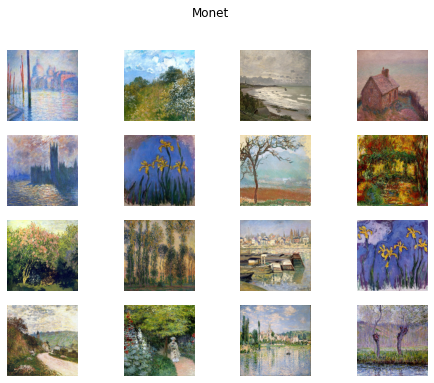

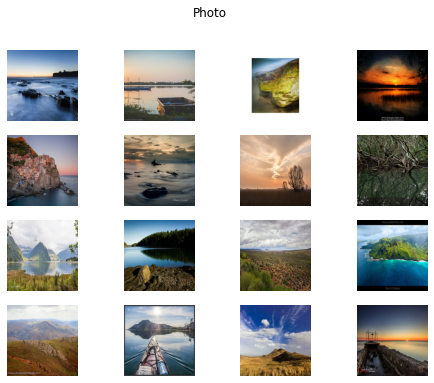

In [ ]:
import matplotlib.pyplot as plt
# show images function
def show_images(images,label):
  r = np.random.choice(np.arange(500),16,replace=False)
  plt.figure(figsize=(8,6))
  plt.suptitle(label)
  for k,i in enumerate(r):
    plt.subplot(4,4,k+1)
    plt.imshow(images[i]/255)
    plt.axis('off')

# show images of photo and monet
show_images(train_monet,'Monet')
show_images(train_photo,'Photo')

# Install requirements

In [ ]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-zi54wjyq
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-zi54wjyq
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=751a332101bd0b7ecae697bfbacff8f2646d3653821b02e078dbfd01a22d85e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ma62nk9/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


# Generator model
This generator consits of 3 main parts; encoder, residual block and decoder.  Convolutional layers and instancenormalization are used in each part.

In [ ]:
# import libraries
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Conv2D,Conv2DTranspose,BatchNormalization
from keras.layers import Input,LeakyReLU,Activation,Concatenate
from keras.models import Model,Sequential
from keras.utils import plot_model
from keras.optimizers import Adam

# define residual block
def Resnet(input):
  # using 2 conv2d layers with relu activation and instance normalization
	model = Conv2D(200,3,padding='same')(input)
	model = InstanceNormalization(axis=-1)(model)
	model = Activation('relu')(model)
	model = Conv2D(200,3,padding='same')(model)
	model = InstanceNormalization(axis=-1)(model)
  # concatenation of input to output
	model = Concatenate()([model, input])
	return model

# define generator model using conv2d, conv2dtranspose and instance normalization with 6 residual blocks
def Generator():
  # encoder part with conv2d
	input_gen = Input(shape=(256,256,3))
  # dimension reduction
	model = Conv2D(50,7,padding='same')(input_gen)
	model = InstanceNormalization(axis=-1)(model)
	model = Activation('relu')(model)
	model = Conv2D(100,3,2,padding='same')(model)
	model = InstanceNormalization(axis=-1)(model)
	model = Activation('relu')(model)
	model = Conv2D(200,3,2,padding='same')(model)
	model = InstanceNormalization(axis=-1)(model)
	model = Activation('relu')(model)
  # 6 residual blocks
	for _ in range(6):
		model = Resnet(model)
  # decoder parts with conv2dtranspose and conv2d
  # dimension increase
	model = Conv2DTranspose(100,3,2,padding='same')(model)
	model = InstanceNormalization(axis=-1)(model)
	model = Activation('relu')(model)
	model = Conv2DTranspose(50,3,2,padding='same')(model)
	model = InstanceNormalization(axis=-1)(model)
	model = Activation('relu')(model)
	model = Conv2D(3,7,padding='same')(model)
	model = InstanceNormalization(axis=-1)(model)
	model = Activation('tanh')(model)
	model = Model(input_gen, model)
	return model

# Discriminator model
This discriminator consits of 2 main parts; feature extraction and patch decision.  Convolutional layers and instancenormalization are used in each part.

In [ ]:
# define discriminator model using conv2d and instance normalization with leakyrelu activation
def Discriminator():
  # feature extraction with dimension reduction
	input_disc = Input(shape=(256,256,3))
	model = Conv2D(500,4,2,padding='same')(input_disc)
	model = LeakyReLU(alpha=0.2)(model)
	model = Conv2D(100,4,2,padding='same')(model)
	model = InstanceNormalization(axis=-1)(model)
	model = LeakyReLU(alpha=0.2)(model)
	model = Conv2D(200,4,2,padding='same')(model)
	model = InstanceNormalization(axis=-1)(model)
	model = LeakyReLU(alpha=0.2)(model)
	model = Conv2D(500,4,2,padding='same')(model)
  # patch decision with 16*16 image input
	model = InstanceNormalization(axis=-1)(model)
	model = LeakyReLU(alpha=0.2)(model)
	model = Conv2D(500,4,padding='same')(model)
	model = InstanceNormalization(axis=-1)(model)
	model = LeakyReLU(alpha=0.2)(model)
	model = Conv2D(1,4,padding='same')(model)
	model = Model(input_disc,model)
  # compile model with mse loss function and adam optimizer and loss_weights=0.5
	model.compile(loss='mse',optimizer=Adam(lr=0.0002,beta_1=0.5),loss_weights=[0.5])
	return model

# CycleGAN model
In this code CycleGAN model is created by using generator and discriminator.

In [ ]:
# define cyclegan model
def CycleGAN(gen1,disc,gen2):
  # make generator trainable and freeze other parts
  gen1.trainable = True
  gen2.trainable = False
  disc.trainable = False
  # adversarial model
  input_gen = Input(shape=(256,256,3))
  gen1_out = gen1(input_gen)
  disc_out = disc(gen1_out)
  # identity model
  input_iden = Input(shape=(256,256,3))
  iden_out =  gen1(input_iden)
  # forward cycle model
  forw_out = gen2(gen1_out)
  # backward model
  gen2_out = gen2(input_iden)
  back_out = gen1(gen2_out)
  # create and compile model with loss_weights=[1,5,10,10]
  model = Model([input_gen,input_iden],[disc_out,iden_out,forw_out,back_out])
  model.compile(loss=['mse','mae','mae','mae'],loss_weights=[1,5,10,10],
                optimizer=Adam(lr=0.0002, beta_1=0.5))
  return model

# generators and discriminators for domain a and b
gen_A2B = Generator()
gen_B2A = Generator()
disc_A = Discriminator()
disc_B = Discriminator()
# cyclegan models for domain a and b
cycle_A2B2A = CycleGAN(gen_A2B,disc_B,gen_B2A)
cycle_B2A2B = CycleGAN(gen_B2A,disc_A,gen_A2B)

# Update discriminator and generator in CycleGAN model
Train CycleGAN model using train_on_batch method in 5000 steps.

In [ ]:
from time import time
# create fake data and fake label
def Fake(gen,data):
	X = gen.predict(data)
	y = np.zeros((len(X),16,16,1))
	return X, y

# select real data and create real label
def Real(dataset):
	ix = np.random.randint(0,dataset.shape[0],1)
	X = dataset[ix]
	y = np.ones((1,16,16,1))
	return X, y

# normalize data
train_monet2 = train_monet/255 *2 -1
train_photo2 = train_photo/255 *2 -1
test_monet2 = test_monet/255 *2 -1
test_photo2 = test_photo/255 *2 -1
# define num of epochs
epochs = 10
steps = epochs*len(train_photo2)
# steps for evaluation of model
check = [100,500,2000,3500,steps]
output_A2B = []
output_B2A = []
q = 0
for i in range(steps):
  t1 = time()
  # select real data
  X_realA, y_realA = Real(train_photo2)
  X_realB, y_realB = Real(train_monet2)
  # create fake data
  X_fakeA, y_fakeA = Fake(gen_B2A, X_realB)
  X_fakeB, y_fakeB = Fake(gen_A2B, X_realA)
  # update cycle_B2A2B model
  cycle_B2A2B.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
  # update discriminator a for real and fake data
  dA_loss1 = disc_A.train_on_batch(X_realA, y_realA)
  dA_loss2 = disc_A.train_on_batch(X_fakeA, y_fakeA)
  # update cycle_A2B2A model
  cycle_A2B2A.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
  # update discriminator b for real and fake data
  dB_loss1 = disc_B.train_on_batch(X_realB, y_realB)
  dB_loss2 = disc_B.train_on_batch(X_fakeB, y_fakeB)
  # print model losses and runtime
  print('steps=%d  disc_A_loss=[%.2f,%.2f]  disc_B_loss=[%.2f,%.2f]  time=%.2fs' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2,time()-t1))
  # model evaluation
  if (i+1)==check[q]:
    output_A2B.append(gen_A2B.predict(test_photo2))
    output_B2A.append(gen_B2A.predict(test_monet2))
    q = q+1
  

Streaming output truncated to the last 5000 lines.
steps=1  disc_A_loss=[0.31,4.70]  disc_B_loss=[0.51,3.35]  time=39.50s
steps=2  disc_A_loss=[2.92,2.09]  disc_B_loss=[1.54,1.62]  time=0.76s
steps=3  disc_A_loss=[1.22,3.73]  disc_B_loss=[1.01,6.98]  time=0.77s
steps=4  disc_A_loss=[2.94,4.97]  disc_B_loss=[0.73,2.51]  time=0.77s
steps=5  disc_A_loss=[1.02,2.74]  disc_B_loss=[1.82,2.86]  time=0.77s
steps=6  disc_A_loss=[0.46,0.56]  disc_B_loss=[1.21,1.86]  time=0.77s
steps=7  disc_A_loss=[0.46,0.60]  disc_B_loss=[0.78,1.36]  time=0.76s
steps=8  disc_A_loss=[0.91,0.48]  disc_B_loss=[0.69,0.70]  time=0.76s
steps=9  disc_A_loss=[0.83,0.43]  disc_B_loss=[0.72,0.53]  time=0.76s
steps=10  disc_A_loss=[0.36,0.61]  disc_B_loss=[0.40,1.21]  time=0.77s
steps=11  disc_A_loss=[0.45,0.36]  disc_B_loss=[0.22,0.48]  time=0.76s
steps=12  disc_A_loss=[0.23,0.35]  disc_B_loss=[0.21,0.34]  time=0.76s
steps=13  disc_A_loss=[0.14,0.34]  disc_B_loss=[0.15,0.39]  time=0.76s
steps=14  disc_A_loss=[0.11,0.53] 

# Showing model results

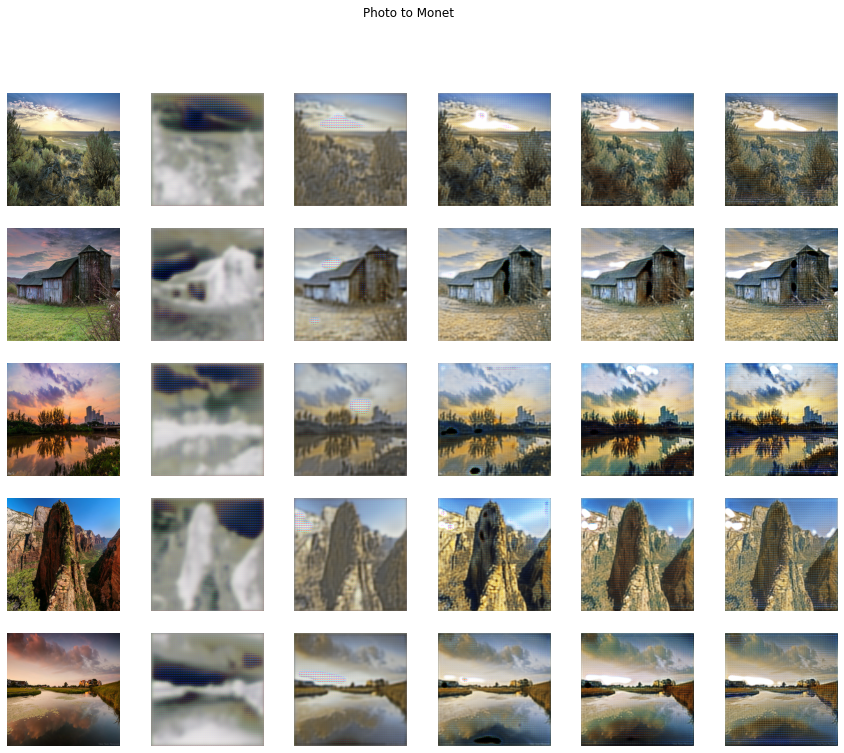

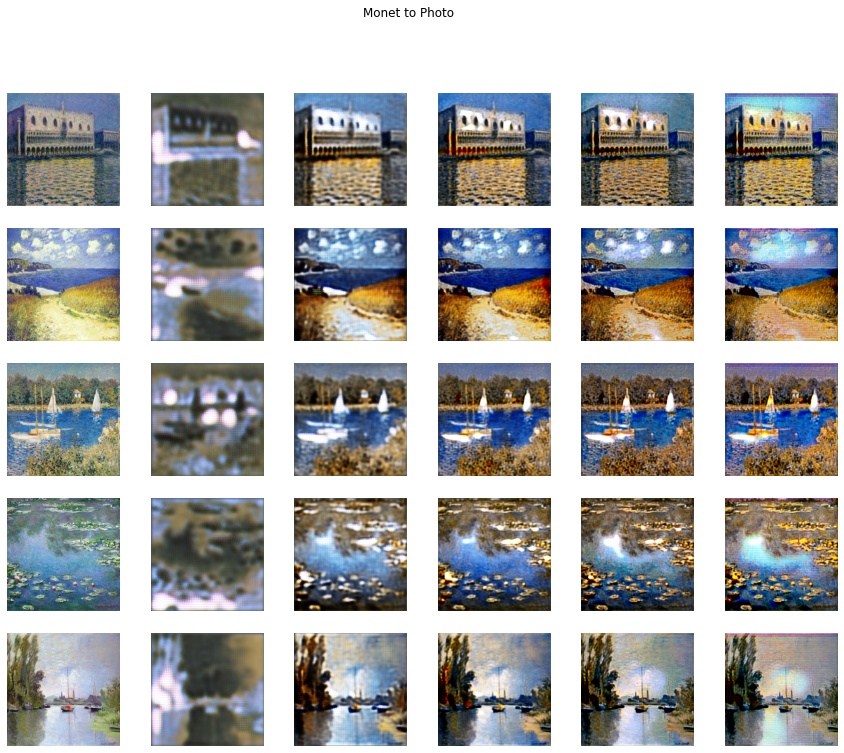

In [ ]:
# selecting random samples
k = np.random.choice(np.arange(50),5,replace=False)
temp_A = np.array(output_A2B)
temp_B = np.array(output_B2A)
plt.figure(figsize=(15,12))
plt.suptitle('Photo to Monet')
q = 1
# showing results of photo to monet
for i in k:
  plt.subplot(5,6,q)
  plt.imshow(test_photo[i]/255)
  plt.axis('off')
  q = q+1
  for j in range(len(output_A2B)):
    plt.subplot(5,6,q)
    plt.imshow((temp_A[j,i]+1)/2)
    plt.axis('off')
    q = q+1

# selecting random samples
k = np.random.choice(np.arange(50),5,replace=False)
plt.figure(figsize=(15,12))
plt.suptitle('Monet to Photo')
q = 1
# showing results of monet to photo
for i in k:
  plt.subplot(5,6,q)
  plt.imshow(test_monet[i]/255)
  plt.axis('off')
  q = q+1
  for j in range(len(output_A2B)):
    plt.subplot(5,6,q)
    plt.imshow((temp_B[j,i]+1)/2)
    plt.axis('off')
    q = q+1